# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [1]:
import pandas as pd
import numpy as np
# 모델링
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import optuna
from optuna.samplers import TPESampler

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    mean_squared_error
)
from context_data import (
    context_data_load,
    context_data_split
)

C:\Users\smile\AppData\Local\Temp\ipykernel_21676\1293233317.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\smile\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 데이터 셋 읽어오기 / 학습, 검증 데이터 분리

In [2]:
# DATA LOAD
data = context_data_load()

# Train/Valid Split
data = context_data_split(data)

c:\Users\smile\OneDrive\Documents\GitHub\LG_aimers_B2BEST\context_data.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  'train':context_train.fillna(0),
c:\Users\smile\OneDrive\Documents\GitHub\LG_aimers_B2BEST\context_data.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  'test':context_test.fillna(0),


In [3]:
data['train'] # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,lead_desc_length,...,product_count,timeline_count,idit_all,bant_submit_count,com_reg_count,idx_count,lead_log,lead_count,enterprise_count,enterprise_weight
0,1.00,0,0,0.066667,0,0,0,0.0,0,62,...,0,0,0,0,0,0,4.127134,0,0,0.0
1,1.00,0,0,0.066667,1,0,0,12.0,1,96,...,0,0,0,0,0,0,4.564348,0,1,0.0
2,1.00,1,0,0.088889,2,0,0,144.0,2,56,...,0,0,0,0,0,0,4.025352,0,1,0.0
3,1.00,1,0,0.088889,3,0,0,0.0,3,44,...,0,0,0,0,0,1,3.784190,0,0,0.0
4,1.00,1,0,0.088889,4,1,0,0.0,4,97,...,0,0,0,0,0,1,4.574711,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55775,1.00,42,0,0.000000,35107,0,1,0.0,2,200,...,0,0,0,0,1,1,5.298317,0,0,0.0
55776,0.75,9,0,0.040000,35108,1,0,0.0,3,70,...,0,0,0,0,1,1,4.248495,0,0,0.0
55777,0.75,38,0,0.040000,35109,1,0,0.0,2,34,...,0,0,0,0,1,1,3.526361,0,0,0.0
55778,1.00,38,0,0.040000,35110,4,0,0.0,3,377,...,0,0,0,0,1,1,5.932245,0,0,0.0


In [4]:
x_train, x_val, y_train, y_val = data['X_train'], data['X_valid'], data['y_train'], data['y_valid']
# 중요도 카테고리 위쪽만 학습해보기

## 3. 모델

### 3-1. RandomForestRegressor 학습

#### 모델 정의 

In [7]:
# Instantiate model 
model = RandomForestRegressor(random_state=42)

#### 모델 학습

In [10]:
# Train the model on training data
model.fit(x_train.fillna(0), y_train)

RandomForestRegressor(random_state=42)

### 3-2. RandomForestRegressor 하이퍼파라미터 튜닝

In [5]:
def objective(trial):
    model = RandomForestRegressor(
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        max_depth=trial.suggest_int("max_depth", 3, 6),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        bootstrap=trial.suggest_categorical("bootstrap", [True, False]),
        random_state=42  # Setting random_state for reproducibility
    )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    return mean_squared_error(y_val, y_pred)

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="random_forest_regressor", direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=500)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  500
Best trial:
  Value:  0.05821751699154011
  Params: 
    n_estimators: 105
    max_depth: 6
    min_samples_split: 2
    min_samples_leaf: 4
    bootstrap: True


In [6]:
model = RandomForestRegressor(**trial.params, verbose=False)

In [7]:
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=4, n_estimators=105,
                      verbose=False)

### 3-3. Randomclassifier 학습

#### 모델 정의 

In [ ]:
# Instantiate model 
model = RandomForestClassifier(random_state=42)

#### 모델 학습

In [ ]:
# Train the model on training data
model.fit(x_train.fillna(0), y_train)

RandomForestClassifier(random_state=42)

### 3-4. Randomclassifier 하이퍼파라미터 튜닝

In [5]:
def objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        max_depth=trial.suggest_int("max_depth", 3, 6),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        bootstrap=trial.suggest_categorical("bootstrap", [True, False]),
        random_state=42  # Setting random_state for reproducibility
    )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    return f1_score(y_val, y_pred, labels=[True, False])

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="random_forest_classifier", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=500)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  500
Best trial:
  Value:  0.9118266626542281
  Params: 
    n_estimators: 500
    max_depth: 6
    min_samples_split: 9
    min_samples_leaf: 9
    bootstrap: False


In [6]:
model = RandomForestClassifier(**trial.params, verbose=False)

In [7]:
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=6, min_samples_leaf=9,
                       min_samples_split=9, n_estimators=500, verbose=False)

### 모델 성능 보기

In [8]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [9]:
# classifier
pred = model.predict(x_val.fillna(0))
#pred  = pred.astype(bool)
get_clf_eval(y_val, pred)

오차행렬:
 [[9108 1124]
 [ 626 9606]]

정확도: 0.9145
정밀도: 0.9357
재현율: 0.8901
F1: 0.9124


In [9]:
#regressor
pred = model.predict(x_val)
pred = [1 if x >= 0.5 else 0 for x in pred]
get_clf_eval(y_val, pred)

오차행렬:
 [[9569  663]
 [ 930 9302]]

정확도: 0.9222
정밀도: 0.9114
재현율: 0.9352
F1: 0.9232


## 4. 제출하기

### 테스트 데이터 예측

In [10]:
# 예측에 필요한 데이터 분리
test_pred = model.predict(data['test'].drop(["is_converted", "id"], axis=1))

In [ ]:
#classifier
sum(test_pred) # True로 예측된 개수

1391

In [11]:
#Regressor
test_pred = [True if x >= 0.5 else False for x in test_pred]
sum(test_pred) # True로 예측된 개수

2383

In [37]:
# 변수명을 가져오기
train = pd.read_csv('train_final.csv', low_memory=False)
feature_names = x_train.columns

# 변수 중요도 출력
importances = model.feature_importances_

# 변수명과 중요도
for feature, imp in zip(feature_names, importances):
    print(f"{feature}: {imp}")

bant_submit: 0.008740056405574475
customer_country: 0.0038227762487020173
business_unit: 0.0030329067713004924
com_reg_ver_win_rate: 0.016650339920661762
customer_idx: 0.3003676958728696
customer_type: 0.2638575873479664
enterprise: 2.3192300367645677e-05
historical_existing_cnt: 0.0014473930878926063
customer_job: 0.0001447697936870326
lead_desc_length: 0.0014433536883623236
inquiry_type: 0.0037088226120810786
product_category: 0.0036463326092736493
product_subcategory: 0.0036835762901366895
product_modelname: 2.997100629483806e-05
customer_position: 8.016481906402021e-05
response_corporate: 0.030275682914664738
expected_timeline: 0.00019116419146598045
ver_cus: 0.00017035395831110426
ver_pro: 0.0
ver_win_rate_x: 0.00016555668626991774
ver_win_ratio_per_bu: 0.000490420658246285
business_area: 0.00013464354145856618
business_subarea: 0.0018856889331613958
lead_owner: 0.07561405401126887
category: 0.0012070144283201818
product_count: 0.0003135041338719327
timeline_count: 0.0
idit_all: 2

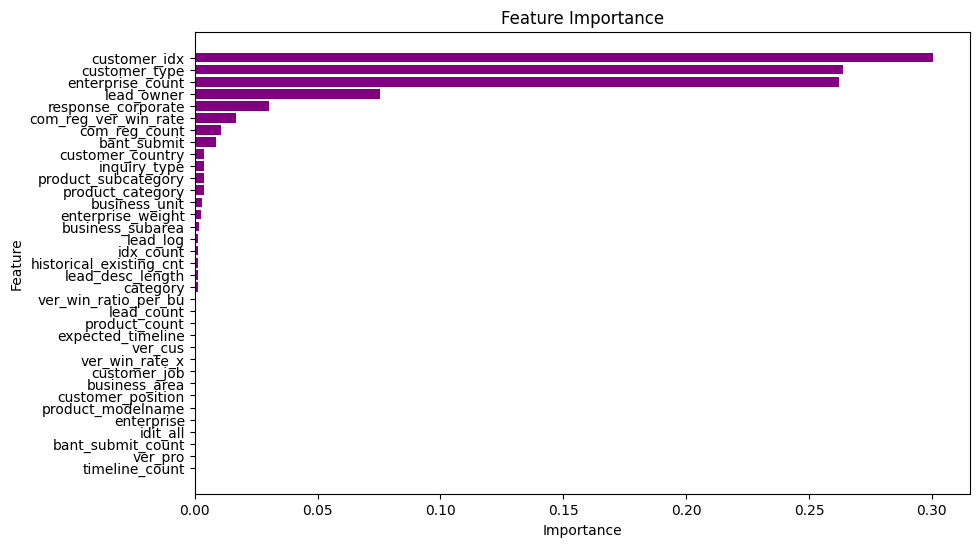

In [42]:
import matplotlib.pyplot as plt

# 변수 중요도를 가져와 DataFrame으로 변환
importances_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': model.feature_importances_})

# 변수 중요도를 Importance 기준으로 내림차순 정렬
importances_df = importances_df.sort_values(by='Importance', ascending=True)

# 변수 중요도를 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='purple')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

### 제출 파일 작성

In [12]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred
df_sub["is_converted"] = df_sub["is_converted"].astype(bool)
df_sub

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,True
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,True
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,True
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,False
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,NaN,...,LGESP,NaN,0,0,NaN,NaN,NaN,NaN,97,False
5267,7979,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,...,LGEUS,NaN,0,0,NaN,NaN,NaN,NaN,438,True
5268,12887,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,NaN,...,LGESP,less than 3 months,0,0,NaN,NaN,NaN,NaN,97,False
5269,17530,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,...,LGEDG,NaN,0,0,NaN,NaN,NaN,NaN,429,True


In [14]:
# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [15]:
# 제출 파일 저장 (classifier)
df_sub.to_csv("submission_rfc.csv", index=False)

In [13]:
# 제출 파일 저장 (regressor)
df_sub.to_csv("submission_rfr.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**